In [15]:
import boto3
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

import numpy as np
from collections import Counter
import os

import seaborn as sns
from matplotlib import pyplot as plt
% matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE

In [2]:
DATA_PATH = os.path.join(os.getcwd(),'Data')

In [3]:
os.listdir(DATA_PATH)

['installments_payments.csv.zip',
 'previous_application.csv.zip',
 'HomeCredit_columns_description.csv',
 'bureau.csv.zip',
 '.ipynb_checkpoints',
 'submission.csv',
 'bureau_balance.csv.zip',
 'application_train.csv.zip',
 'credit_card_balance.csv.zip',
 'application_test.csv.zip',
 'sample_submission.csv.zip',
 'POS_CASH_balance.csv.zip']

In [4]:
description = pd.read_csv(os.path.join(DATA_PATH,'HomeCredit_columns_description.csv'), encoding='latin-1')
app_train = pd.read_csv(os.path.join(DATA_PATH,'application_train.csv.zip'))
app_test = pd.read_csv(os.path.join(DATA_PATH,'application_test.csv.zip'))
bureau = pd.read_csv(os.path.join(DATA_PATH,'bureau.csv.zip'))
bureau_balance = pd.read_csv(os.path.join(DATA_PATH,'bureau_balance.csv.zip'))
credit_card_balance = pd.read_csv(os.path.join(DATA_PATH,'credit_card_balance.csv.zip'))
POS_CASH_balance = pd.read_csv(os.path.join(DATA_PATH,'POS_CASH_balance.csv.zip'))
previous_app = pd.read_csv(os.path.join(DATA_PATH,'previous_application.csv.zip'))

In [18]:
for dateframe in [description,
                  app_train,
                  app_test,
                  bureau,
                  bureau_balance,
                  credit_card_balance,
                  POS_CASH_balance,
                  previous_app]:
    dateframe = dateframe[[col for col in dateframe.columns if len(dateframe[col].value_counts())!=1]]

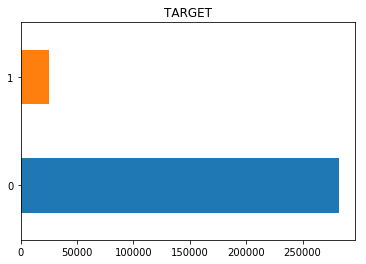

In [19]:
app_train.TARGET.value_counts().plot(kind='barh', title='TARGET');

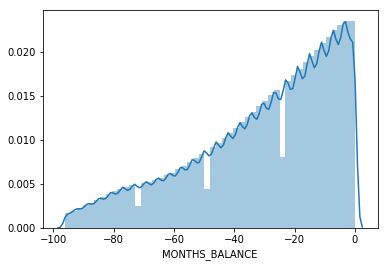

In [6]:
# bureau balance
sns.distplot(bureau_balance.MONTHS_BALANCE);

#### BUREAU

In [7]:
ml_bureau = pd.DataFrame({'SK_ID_CURR':bureau.SK_ID_CURR})

In [8]:
def bureau_aggregation(new_df, df):
    AGGREGATIONS = [{'groupby':['SK_ID_CURR'],'select':'SK_ID_BUREAU','agg':'nunique'},
                    {'groupby':['SK_ID_CURR'],'select':'CREDIT_TYPE','agg':'nunique'},
                    {'groupby':['SK_ID_CURR'],'select':'DAYS_CREDIT','agg':'mean'},
                    {'groupby':['SK_ID_CURR'],'select':'DAYS_CREDIT','agg':'max'},
                    {'groupby':['SK_ID_CURR'],'select':'CREDIT_DAY_OVERDUE','agg':'mean'},
                    {'groupby':['SK_ID_CURR'],'select':'CREDIT_DAY_OVERDUE','agg':'max'},      
                   ]
    for agg in AGGREGATIONS:
        # features to select
        all_features = list(set(agg['groupby'] + [agg['select']]))
        # variables name
        new_feature = '{0}_{1}'.format(agg['select'], agg['agg'])
        print(new_feature)
        # perform the groupby
        gp = df[all_features] \
                .groupby(agg['groupby']) \
                [agg['select']] \
                .agg(agg['agg']) \
                .reset_index()  \
                .rename(index=str, columns={agg['select']:new_feature})
        # Merge
        new_df = new_df.merge(gp,on=agg['groupby'],how='left')
    return new_df

In [9]:
ml_bureau = bureau_aggregation(ml_bureau, bureau)

SK_ID_BUREAU_nunique
CREDIT_TYPE_nunique
DAYS_CREDIT_mean
DAYS_CREDIT_max
CREDIT_DAY_OVERDUE_mean
CREDIT_DAY_OVERDUE_max


In [30]:
to_encode = ['CREDIT_ACTIVE','CREDIT_CURRENCY','CREDIT_TYPE']
for col in to_encode:
    le=LabelEncoder()
    le.fit(bureau[col])
    ml_bureau[col] = le.transform(bureau[col])

#### APPLICATION TRAIN

In [20]:
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [25]:
#app_train.INCOME_CREDIT_LEVEL = app_train.AMT_CREDIT / app_train.AMT_INCOME_TOTAL
#app_train.ANNUITY_INCOME_SHARE = app_train.AMT_ANNUITY / app_train.AMT_INCOME_TOTAL
#app_train.GOODS_PRICE_CREDIT_SHARE = app_train.AMT_GOODS_PRICE / app_train.AMT_CREDIT

/home/ec2-user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
app_train.isnull().sum()

SK_ID_CURR                           0
TARGET                               0
NAME_CONTRACT_TYPE                   0
CODE_GENDER                          0
FLAG_OWN_CAR                         0
FLAG_OWN_REALTY                      0
CNT_CHILDREN                         0
AMT_INCOME_TOTAL                     0
AMT_CREDIT                           0
AMT_ANNUITY                         12
AMT_GOODS_PRICE                    278
NAME_TYPE_SUITE                   1292
NAME_INCOME_TYPE                     0
NAME_EDUCATION_TYPE                  0
NAME_FAMILY_STATUS                   0
NAME_HOUSING_TYPE                    0
REGION_POPULATION_RELATIVE           0
DAYS_BIRTH                           0
DAYS_EMPLOYED                        0
DAYS_REGISTRATION                    0
DAYS_ID_PUBLISH                      0
OWN_CAR_AGE                     202929
FLAG_MOBIL                           0
FLAG_EMP_PHONE                       0
FLAG_WORK_PHONE                      0
FLAG_CONT_MOBILE         

In [ ]:
app_train.select_dtypes(include='int')

In [ ]:
train = app_train.select_dtypes(include='int').fillna(0)
test = app_test.select_dtypes(include='int').fillna(0)

In [ ]:
train_obj = app_train.select_dtypes(include='object').fillna('unknown')
test_obj = app_test.select_dtypes(include='object').fillna('unknown')

for col in train_obj.columns.tolist():
    le = LabelEncoder()
    le.fit(train_obj[col])
    train_obj[col] = le.transform(train_obj[col])
    test_obj[col] = le.transform(test_obj[col])

In [ ]:
train = train.join(train_obj)
test = test.join(test_obj)

#### MODELLING

In [ ]:
rfc = RandomForestClassifier(n_estimators=1000, max_depth=60, n_jobs=-1)

In [ ]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_sample(train[list(set(train.columns)-{'TARGET'})], train.TARGET)
print('Resampled dataset shape {}'.format(Counter(y_res)))

In [ ]:
rfc.fit(X_res, y_res)

In [ ]:
y_pred = rfc.predict_proba(test)[:,1]

#### Kaggle submission

In [ ]:
submission = pd.DataFrame({'SK_ID_CURR':test.SK_ID_CURR,
                          'TARGET':y_pred})

In [ ]:
submission.to_csv(os.path.join(DATA_PATH,'submission.csv'), index=False)

In [ ]:
!cd Data; kg submit submission.csv -u kggborahn -p 28121993Borahn,T -c home-credit-default-risk -m "quick test"